# Part 2: Turning Play-By-Play Data into Game Data
<i style="font-size: 0.94em">This notebook is part of a series detailing the creation of models for predicting NFL game outcomes. For the table of contents listing all notebooks in the series, <a href="0.Introduction_NFL_Prediction.ipynb">click here.</a></i>

In the <a href="./1.NFL_Data_Cleaning.ipynb">previous notebook in this series</a>, we cleaned a large .csv file of NFL play-by-play data from 2009-2018. In cleaning the data, I saved multiple gigabytes of memory usage. The final goal here is to use this data to build models that will predict NFL game outcomes more accurately than any human expert.

The simplest approach, and the approach used here, is to change the play data into summarized statistics for each game. Once the per-game summary statistics are finished, we can calculate per-team and per-season averages. We can also turn the per-game statistics into a stat line of a team's performance in a given season before a given game but NOT including the statistics for that particular game. This stat line, of statistics in a certain season up to but not including a certain game, is critical. Why? It represents our ability to predict that game using all information available before the game starts. In other words, this is the data someone would actually have access to before predicting a real game. These summary vectors are also what will be input into our model.

However, that is a later step. First, we must extract the per-game features from the play-by-play data.

## Extracting Game Stats from Play-By-Play
The play-by-play data contains statistics for all NFL games from 2009-2018. In other words, it is every single play in ten season's worth of games for all 32 NFL teams. While this might seem like a lot of plays, the data set is much smaller than typical machine-learning data sets in terms of how many observations it has. Moreover, the reduced set of per-game and per-season statistics for each team will be orders of magnitude smaller than most ML datasets. This will have relevance to fitting and testing our models later.

We track the same data for each game, regardless of the year or the teams. The data also gets calculated in the same way for every game, even though there are about 2500 games total. We can calculate data for the home team and the away team, which effectively doubles the number of game statistic summaries to 5000. The main point is that it's the exact same data points and same method of calculating those points for each game. Hence, it makes sense to create a class that represents each game, and simply create an instance of that class for each team in each game.

## Basic description of the NFLGame class
The NFLGame class uses Pandas to sum up individual stats. Some statistics, such as time of possession, require more complicated calculations and have methods in the NFLGame class defined for them. Offensive stats and defensive stats for the given team are calculated using dataframes sliced from the input frame for offense and defense. After calculation, offensive stats and defensive stats are built into dictionaries and returned. 

A final, comprehensive dictionary representing the entire game is built from the offensive stats dictionary, the defensive stats dictionary, and a few other general stats about the game. These general stats include items such as whether this team is the home or away team and the finishing point differential. The latter is particularly important, as it will serve as the label in training the machine learning and neural network models.

The NFL game class is initialized with a Pandas dataframe containing all the data for one NFL game and the name of a team, taken as a 2 or 3-letter string. The team given should match one of the two teams in the game. The class then calculates a wide variety of offensive stats and defensive stats, along with other basics information like which season the game belongs to (for example, a game on January 1st, 2019 will actually go with games from the 2018 season and not the 2019 season).

Note that a given football game (from the real world) can make two different NFLGame objects, one for the away team and one for the home team. This is because data is tracked across the season for each given team, so we want to extract game stats for one team in order to agglomerate them with other stats from the season.

The full code for the NFLGame class can be seen below. It is long due to calculating many different statistics for a given game. As to which features in particular are extracted, scroll below the code for discussion.

In [1]:
# Class NFLGame calculates the stats of each game given the large CSV of all NFL plays from 2009 to 2018
import pandas as pd

class NFLGame:

    def __init__(self, df: pd.DataFrame, team: str):
        self.df = df
        self.off_df = df.loc[(df["posteam"] == team) & (df["play_type"] != "no_play")]
        self.def_df = df.loc[(df["defteam"] == team) & (df["play_type"] != "no_play")]
        self.team = team
        # Every row should have same gameID. Can get it out of row 0.
        self.game_id = df["game_id"].values[0]
        self.game_date = self.game_id // 100
        self.season = self.get_season()
        self.is_home_team = 1.0 if self.df["home_team"].values[0] == self.team else 0.0

    # Assumes date is int in form YYYYMMDD
    def get_season(self):
        date = self.game_date
        year = date//10000
        month = (date//100) % 100
        # Everything after May counted as 'this year'/this season, everything before
        # May (IE, January and February games) counted as prior season
        return year if month > 5 else year - 1

    def __str__(self):
        return f"Date: {self.game_id} \nTeam: {self.team}\n\n"

    def get_all_stats_dict(self):
        point_differential = self.get_point_differential()
        result = {"game_id": self.game_id,
                  "game_date": self.game_date,
                  "team": self.team,
                  "season": self.season,
                  "point_dif": point_differential,
                  "is_home_team": self.is_home_team
                  }
        off_stat_dict = self.extract_offensive_stats()
        def_stat_dict = self.extract_defensive_stats()
        result |= off_stat_dict | def_stat_dict
        return result

    def print_all_stats(self):
        print(f"============All calculated stats for {self.team}, gameID: {self.game_id}===========")
        stats = self.get_all_stats_dict()
        self.print_stats_dict(stats)

    def print_stats_dict(self, stats: dict):
        start_row = False
        for key in stats:
            if not start_row:
                print(f"  {key:20}: {stats[key]:8}  |  ", end="")
            else:
                print(f"{key:20}: {stats[key]:8}")
            start_row = not start_row
        print()

    def get_point_differential(self):
        last_play_index = self.df.last_valid_index()
        home_score = self.df.loc[last_play_index, "total_home_score"]
        away_score = self.df.loc[last_play_index, "total_away_score"]
        return home_score - away_score if self.is_home_team == 1 else away_score - home_score

    # == Offensive stat calculations start here  ==
    def pass_yards_and_attempts(self):
        df = self.off_df[self.off_df["play_type"] == "pass"]
        return df["yards_gained"].sum(), df.shape[0]

    def rush_yards_and_attempts(self):
        df = self.off_df[self.off_df["play_type"] == "run"]
        return df["yards_gained"].sum(), df.shape[0]

    def get_off_penalties(self):
        # Returns penalty yards and number of penalties
        df = self.df[(self.df["penalty_team"] == self.team) & (self.df["posteam"] == self.team)]
        return df["penalty_yards"].sum(), df.shape[0]

    def get_fg_made_yards(self):
        fg_made = len(self.off_df[self.off_df["field_goal_result"] == "made"])
        total_attempted_yards = 0
        # below checks if any field goals were attempted, keeps code from crashing
        # if no field goals attempted
        if len(self.off_df["field_goal_result"].value_counts()) > 0:
            df = self.off_df[self.off_df["field_goal_attempt"] == 1]
            # This corrects for data sheet tracking field goal attempts by yardline from which
            # attempted, whereas external stats tend to add about ten yards to get the actual
            # distance kicked
            total_attempted_yards = df["kick_distance"].sum()
        return fg_made, total_attempted_yards

    # Gets the total starting field position for this team on offensive or defensive drives.
    # The idea is that this, along with the number of drives, will reflect the performance
    # of special teams and how they contribute to offense or defense
    def get_total_start_pos(self, relevant_df: pd.DataFrame):
        # Adds together total starting position for all drives
        cur_drive = 0
        result = 0
        add_next = False
        # The code below is necessary due to an oddity in the data set.
        # Essentially, at the start of a new drive, the starting position
        # of the drive occurs in the current play if it is not a kickoff.
        # If it is a kickoff, the starting position is given in the subsequent
        # play. 
        # There is probably an easier/cleaner way to do this in Pandas,
        # but dealing with edge cases regarding kickoffs and getting the index
        # afterward has proven quite tricky and cannot get it to work.
        for cur_index in relevant_df.index:
            # This adds the play after kickoffs
            if add_next:
                result += relevant_df["yardline_100"][cur_index]
                add_next = False
            # This checks if it is a new drive
            if cur_drive != relevant_df["drive"][cur_index]:
                cur_drive = relevant_df["drive"][cur_index]
                if relevant_df["play_type"][cur_index] == "kickoff":
                    add_next = True
                else:
                    result += relevant_df["yardline_100"][cur_index]
        return result
    
    # Attempt to refactor above method to not use for loops and iterate through
    # rows in Pandas, which is considered an anti-pattern.
    # In its current state, it is significantly slower than iterating by rows. Not clear why.
    def total_start_pos(self, orig_df: pd.DataFrame):
        # Select all plays where current drive does not equal prior_drive
        df = orig_df[orig_df["drive"] != orig_df["drive"].shift()]
        return_value = df[df["play_type"] != "kickoff"]["yardline_100"].sum()
        kickoff_indexes = df[(df["play_type"] == "kickoff")].index
        after_kickoff_indexes = [i+1 for i in kickoff_indexes if i+1 in self.df.index and i+1 not in kickoff_indexes]
        return_value += self.df.loc[after_kickoff_indexes]["yardline_100"].sum()
        return return_value

    def get_time_possession(self):
        # This approximates TOP by subtracting the time at the start of the last play from that
        # at the start of the first play. Time from END of this drive to START of next drive(for
        # other team) is not counted.
        result = 0
        off_drive_start = self.off_df.groupby("drive")["game_seconds_remaining"].max()
        off_drive_end = self.off_df.groupby("drive")["game_seconds_remaining"].min()
        for start, end in zip(off_drive_start, off_drive_end):
            result += start - end
        return result

    def get_sacks_allowed_sackyards(self):
        df = self.off_df[self.off_df["sack"] == 1]
        df = df[df["yards_gained"] <= 0]
        return df.shape[0], df["yards_gained"].sum()

    # Returns a dict of all offensive stats. Basically runs a few methods first,
    # then builds big dictionary below
    def extract_offensive_stats(self):
        # Call some methods here
        net_passing_yards, passes_attempted = self.pass_yards_and_attempts()
        off_total_rushing, rushes_attempted = self.rush_yards_and_attempts()
        off_pen_yards, off_penalties = self.get_off_penalties()
        fg_made, fg_attempt_yards = self.get_fg_made_yards()
        times_sacked, sacked_yards_lost = self.get_sacks_allowed_sackyards()
        # First downs are counted only from rushing and passing first downs,
        # not from penalties or the first play after a kickoff
        first_downs_earned = self.off_df["first_down_rush"].sum() + \
                             self.off_df["first_down_pass"].sum() + \
                             self.off_df["first_down_penalty"].sum()
        off_stats_dict = {
            "off_drives": len(self.off_df["drive"].value_counts()),
            "off_total_start_pos": self.total_start_pos(self.off_df),
            "completed_passes": self.off_df["complete_pass"].sum(),
            "net_passing_yards": net_passing_yards,
            "passes_attempted": passes_attempted,
            "air_yards": self.off_df["air_yards"].sum(),
            "yards_after_catch": self.off_df["yards_after_catch"].sum(),
            "pass_td": self.off_df["pass_touchdown"].sum(),
            "interceptions_thrown": self.off_df["interception"].sum(),
            "fumbles_made": self.off_df["fumble"].sum(),
            "fumbles_lost": self.off_df["fumble_lost"].sum(),
            "off_total_rushing": off_total_rushing,
            "rushes_attempted": rushes_attempted,
            "rush_td": self.off_df["rush_touchdown"].sum(),
            "off_pen_yards": off_pen_yards,
            "off_penalties": off_penalties,
            "time_possession": self.get_time_possession(),
            "fg_attempts": self.off_df["field_goal_attempt"].sum(),
            "fg_made": fg_made,
            "fg_attempt_yards": fg_attempt_yards,
            "times_sacked": times_sacked,
            "qb_was_hit": self.off_df["qb_hit"].sum(),
            "first_downs_earned": first_downs_earned,
            "sacked_yards_lost": sacked_yards_lost
        }
        return off_stats_dict

    def print_offensive_stats(self):
        print(f"==============Offensive stats for {self.team}, gameID: {self.game_id}==============")
        stats = self.extract_offensive_stats()
        self.print_stats_dict(stats)

    # =============== Defensive stat calculations start here below ==============
    def get_opp_fg_attempt_total_yards(self):
        total_attempted_yards = 0
        # below checks if any field goals were attempted, keeps code from crashing
        # if no field goals made
        if len(self.def_df["field_goal_result"].value_counts()) > 0:
            df = self.def_df[self.def_df["field_goal_attempt"] == 1]
            total_attempted_yards = df["kick_distance"].astype(float).sum()
        return total_attempted_yards

    def get_def_penalties(self):
        df = self.df[(self.df["penalty_team"] == self.team) & (self.df["defteam"] == self.team)]
        return df["penalty_yards"].astype(float).sum(), df.shape[0]

    def pass_allowed_yards_attempts(self):
        df = self.def_df[self.def_df["play_type"] == "pass"]
        return df["yards_gained"].astype(float).sum(), df.shape[0]

    def rush_allowed_yards_attempts(self):
        # rush attempts slightly off 3rd party numbers, but this appears to be because
        # the given dataset counts kneel-downs as 'no play' whereas others count
        # them as run/rush
        df = self.def_df[self.def_df["play_type"] == "run"]
        return df["yards_gained"].astype(float).sum(), df.shape[0]

    def get_sacks_sackyards(self):
        df = self.def_df[self.def_df["sack"] == 1]
        df = df[df["yards_gained"] <= 0]
        return df.shape[0], df["yards_gained"].astype(float).sum()

    def get_picks_6s(self):
        df = self.def_df[(self.def_df["interception"] == 1) & (self.def_df["touchdown"] == 1)]
        pick_6s = df.shape[0]
        return pick_6s

    # Returns a dict of all offensive stats. Basically runs a few methods first,
    # then builds big dictionary below
    def extract_defensive_stats(self):
        p_yards_allowed, opponent_p_attempts = self.pass_allowed_yards_attempts()
        r_yards_allowed, opponent_r_attempts = self.rush_allowed_yards_attempts()
        sacked_their_qb, sack_yards = self.get_sacks_sackyards()
        def_penalty_yards, def_num_penalties = self.get_def_penalties()
        first_downs_allowed = self.def_df["first_down_rush"].sum() + \
                              self.def_df["first_down_pass"].sum() + \
                              self.def_df["first_down_penalty"].sum()
        
        def_stats_dict = {
            "opp_fg_attempts": self.def_df["field_goal_attempt"].sum(),
            "opp_fg_attempt_yards": self.get_opp_fg_attempt_total_yards(),
            "interceptions_caught": self.def_df["interception"].sum(),
            "forced_fumbles": self.def_df["fumble_forced"].sum(),
            "def_penalty_yards": def_penalty_yards,
            "def_num_penalties": def_num_penalties,
            "first_downs_allowed": first_downs_allowed,
            "def_drives": len(self.def_df["drive"].value_counts()),
            "num_def_plays": self.def_df.shape[0],
            "oppo_start_pos_total": self.total_start_pos(self.def_df),
            "p_yards_allowed": p_yards_allowed,
            "opponent_p_attempts": opponent_p_attempts,
            "pass_td_allowed": self.def_df["pass_touchdown"].sum(),
            "r_yards_allowed": r_yards_allowed,
            "opponent_r_attempts": opponent_r_attempts,
            "rush_td_allowed": self.def_df["rush_touchdown"].sum(),
            "pick_6s": self.get_picks_6s(),
            "hit_their_qb": self.def_df["qb_hit"].sum(),
            "sacked_their_qb": sacked_their_qb,
            "sack_yards": sack_yards,
            "tackles_for_loss": self.def_df["tackled_for_loss"].sum()}
        return def_stats_dict

    def print_defensive_stats(self):
        print(f"============Defensive stats for {self.team}, gameID: {self.game_id}============")
        stats = self.extract_defensive_stats()
        self.print_stats_dict(stats)

# Feature Selection
At this point, it is best to cast a wide net in terms of extracting features. While future models may or may not need all the features extracted, it is better to extract more features now and throw them out later if modelling shows them to have little impact. Why? Because it is impossible to measure the impact of a feature unless it has been extracted and used to train and test some type of model. If we only chose a few features and did not test them against others, how could we be sure we've made a reasonable choice? Furthermore, while an extremely large dataset with billions of items might demand a more stringent reduction at this stage, the NFL data set is relatively small in terms of games, so a stringent reduction in features is unnecessary at this point.

In selecting features, I favored first-order statistics such as total passes and completed passes over things like completion rate (which is the simple division of completed passes by total passes). Why? Because a neural network or other machine-learning method may be able to discover sublter relationships between the two that are more predictive of game outcomes than simple division. For example, does someone who throws only a few passes and completes nearly all do better than someone who throws far more but completes a lower proportion? And how does the number of passes thrown and caught relate to things like running yards? A simpler measure like completion percentage may leave out such complex relationships, which the neural network and other ML methods can discover and utilize.

By a similar logic, I extracted features like total start position on the field plus number of offensive drives rather than dividing them to get average starting field position.

# List of Features and Verification of Accuracy
The following code snippet opens the big pickle file of all plays in the NFL from 2009-2018, which was produced in the <a href="">data cleaning notebook preceding this one</a>. From this larger data set, it extracts the offensive and defensive stats for the Dallas Cowboys from the December 17th, 2017 game between the Cowboys and the Oakland Raiders. 

To verify the accuracy of these calculations, the extracted stats are then compared with 3rd party stats (specifically, those from <a href="https://www.pro-football-reference.com/boxscores/201712170rai.htm"> pro-football-reference.com</a>).


In [2]:
import pandas as pd

directory = "./Data/"
input_file_name = "cleaned_data_pickle.pkl"

df = pd.read_pickle(directory+input_file_name)

current_game = df.loc[df["game_id"] == 2017121711]
team = "DAL"
test_game = NFLGame(current_game, team)
my_stats = test_game.get_all_stats_dict()
their_stats = {
    "game_id": 2017121711,
    "game_date": 201712171,
    "team": "DAL",
    "season": 2017,
    "point_dif": 3,
    "is_home_team": 0,
    "off_drives": 9,
    "off_total_start_pos": -1,
    "completed_passes": 18,
    "net_passing_yards":  204,
    "passes_attempted":  27,
    "air_yards": -1,
    "yards_after_catch": -1,
    "pass_td": 0,
    "interceptions_thrown": 2,
    "fumbles_made": 0,
    "fumbles_lost": 0,
    "off_total_rushing": 126,
    "rushes_attempted": 31,
    "rush_td": 2,
    "off_pen_yards": 30,
    "off_penalties": 3,
    "time_possession": 1940,
    "fg_attempts": 2,
    "fg_made": 2,
    "fg_attempt_yards": 64,
    "times_sacked": 2,
    "qb_was_hit": 5,
    "first_downs_earned": 21,
    "sacked_yards_lost": -8,
    "opp_fg_attempts": 2,
    "opp_fg_attempt_yards": 78,
    "interceptions_caught":  0,
    "forced_fumbles":  2,
    "def_penalty_yards": 70,
    "def_num_penalties": 4,
    "first_downs_allowed": 19,
    "def_drives": 9,
    "num_def_plays":  74,
    "oppo_start_pos_total": -1,
    "p_yards_allowed": 171,
    "opponent_p_attempts": 38,
    "pass_td_allowed": 2,
    "r_yards_allowed": 122,
    "opponent_r_attempts": 23,
    "rush_td_allowed":  0,
    "pick_6s": 0,
    "hit_their_qb":  5,
    "sacked_their_qb": 0,
    "sack_yards":  0,
    "tackles_for_loss": 4
}
print("===Comparison of calculated stats vs 3rd party stats===")
print("-1 indicates 3rd party stat not present")
for key in my_stats.keys():
    print(f"{key:20} | Mine:{my_stats[key]:12} | 3rd Party:{their_stats[key]:10}")
    


===Comparison of calculated stats vs 3rd party stats===
-1 indicates 3rd party stat not present
game_id              | Mine:  2017121711 | 3rd Party:2017121711
game_date            | Mine:    20171217 | 3rd Party: 201712171
team                 | Mine:DAL          | 3rd Party:DAL       
season               | Mine:        2017 | 3rd Party:      2017
point_dif            | Mine:           3 | 3rd Party:         3
is_home_team         | Mine:         0.0 | 3rd Party:         0
off_drives           | Mine:           9 | 3rd Party:         9
off_total_start_pos  | Mine:       668.0 | 3rd Party:        -1
completed_passes     | Mine:        18.0 | 3rd Party:        18
net_passing_yards    | Mine:       204.0 | 3rd Party:       204
passes_attempted     | Mine:          29 | 3rd Party:        27
air_yards            | Mine:       293.0 | 3rd Party:        -1
yards_after_catch    | Mine:        81.0 | 3rd Party:        -1
pass_td              | Mine:         0.0 | 3rd Party:         0
intercep

# Discussion of discrepancies
Negative ones, as noted above, indicated that the 3rd party does not have a statistic corresponding to the extracted feature. Specifically, pro-football-reference.com does not appear to track air yards, yards after catch, total offensive start position (IE, the sum of starting field position for each offensive drive), or total defensive start position.

Besides these, a few differences jump out when examining the sheet. The number of passes attempted is slightly different, with my calculations getting 2 more passes attempted than the third party statistics. The number of pass attempts is a simple sum along a column, so a mathematical error is unlikely. Rather, the discrepancy may arise from a slightly different tabulation of pass attempts. The spreadsheet seems to count pass attempts in penalized plays, whereas the third party stats may not. The third party stats might also count interceptions or negative-yardage passing plays differently from the spreadsheet. A minor difference in number of attempted rushes likely stems from a similar cause. I suspect the 1 yard difference in rushing arises from my code specifically discounting the -1 yard resulting from kneeldowns.

A second notable difference is in time of possession. The code in the NFLGame class calculates this by subtracting the number of seconds on the game clock in one play from the subsequent play, and totalling all of these over a drive. However, it does not count passage between drives (IE, on special teams plays). Hence, there is a slight discrepancy, and the number of seconds does not add up to 3600 (the number of seconds in one hour of game time). However, this difference should not matter too much as long as time-of-possession is calculated consistently across teams and across seasons.

Finally, the number of first downs earned and opponent's first downs earned differs between my calculated stats and the third party stats. This is, again, due to a difference in calculation. My code calculates this stat as the sum of rushing first downs, penalty first downs, and passing first downs. My statistic does not include things like receiving a kickoff. The third party stats may calculate it in a slightly different way.

# Extracting stats for every team and every game
Now that we have the class written that represents one team's statistics for one game, we can use a simple loop to get all the stats per team per game for the entire dataset, representing every NFL game from 2009-2018. The code below does this.

In [3]:
import time;

def build_per_game_features(df: pd.DataFrame):
    game_id_list = df["game_id"].unique()
    ids_done = 0
    list_of_games = []
    print("Performing per-game feature extraction from play-by-play... (may take a few minutes)")
    for game_id in game_id_list:
        current_game_df = df.loc[df["game_id"] == game_id]
        home_team = current_game_df["home_team"].values[0]
        away_team = current_game_df["away_team"].values[0]
        list_of_games.append(NFLGame(current_game_df, home_team).get_all_stats_dict())
        list_of_games.append(NFLGame(current_game_df, away_team).get_all_stats_dict())
        ids_done += 1
        if ids_done % 100 == 0:
            output_percent = 100*ids_done/len(game_id_list)
            print(f"{output_percent:.3}% done.")
    print("Done.")
    result = pd.DataFrame.from_records(list_of_games)
    return result

output_file_name = "per_game_stats.pkl"
start = time.time()
per_game_stats = build_per_game_features(df)
end = time.time()
print(f"How many seconds to extract all features? {end-start}")
per_game_stats.to_pickle(directory+output_file_name)

Performing per-game feature extraction from play-by-play... (may take a few minutes)
3.96% done.
7.92% done.
11.9% done.
15.8% done.
19.8% done.
23.8% done.
27.7% done.
31.7% done.
35.6% done.
39.6% done.
43.5% done.
47.5% done.
51.5% done.
55.4% done.
59.4% done.
63.3% done.
67.3% done.
71.3% done.
75.2% done.
79.2% done.
83.1% done.
87.1% done.
91.1% done.
95.0% done.
99.0% done.
Done.
How many seconds to extract all features? 100.08622074127197


# How do these stats relate to each other?

While an extensive statistical analysis is not the focus of this series of Jupyter notebooks, there's no harm in taking a look at how the various dimensions (IE, extracted football statistics) relate to each other. A visualization of the correlation matrix is quick and useful.

<b>Because who doesn't like gigantic heat maps?</b>


<AxesSubplot:>

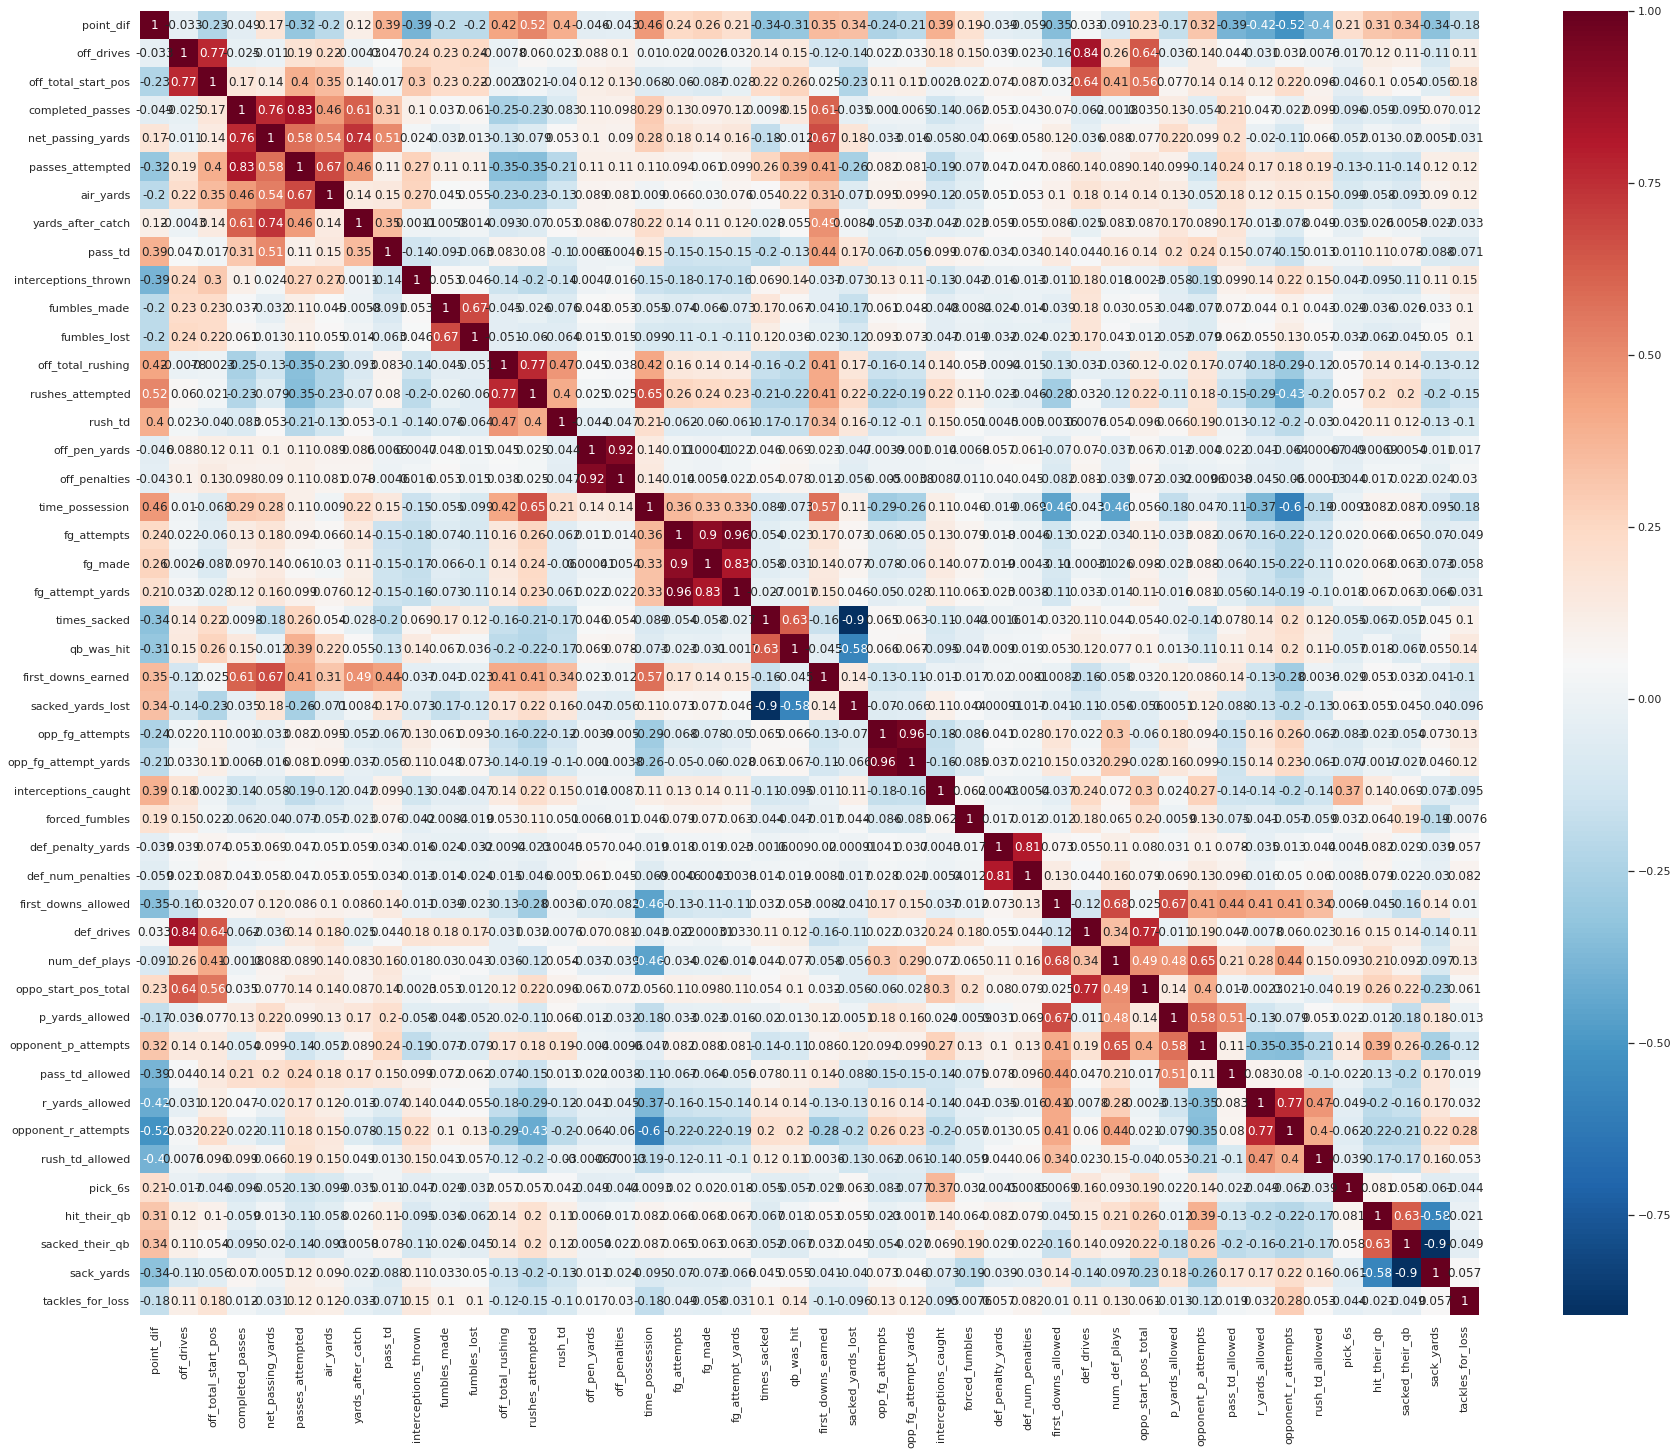

In [8]:
import seaborn as sns

corr_df = per_game_stats.drop(["game_id", "game_date", "team", "season", 
                              "is_home_team"], axis=1)
corr = corr_df.corr()
sns.set(rc={"figure.figsize": (30, 24)})
sns.heatmap(corr, 
                xticklabels=corr_df.columns, 
                yticklabels=corr_df.columns,
                annot=True,
                cmap="RdBu_r")


# Next steps
From here, we'll move into changing our per-game stats into a form suitable to input into machine-learning algorithms. Specifically, as described above, we need a form that summarizes all the information available to someone BEFORE a given game starts, but not including anything about that game that wouldn't be known ahead of time. Specifically, we would know an average or other summary of all game statistics occuring for all games in taht season before the current one, plus a prior season average (or two or more season back). We would also know whether the current game is played at home or away. Hence, what we need is a vector that combines all of these.

The <a href="3.NFL_Game_Data_to_ML_Inputs.ipynb">next section in this Jupyter Notebook series</a> details the transformation of the per-game summarized statistics into a suitable vector representation for input into predictive algorithms
.